In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
plt.style.use(['science', 'notebook', 'dark_background'])
from scipy.interpolate import interp1d
from scipy.integrate import quad

$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$

$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

# Theory

Suppose one has a sequence of wells, each spaced a distance $b$ apart

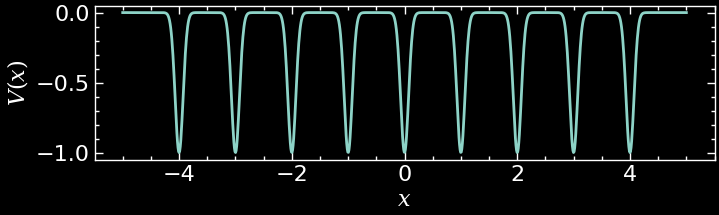

In [3]:
x = np.linspace(-5,5,1000)
y = np.sum([-np.exp(-(x-a)**2 / 0.01) for a in range(-4,5)], axis=0)
plt.figure(figsize=(8,2))
plt.plot(x,y)
plt.ylabel('$V(x)$')
plt.xlabel('$x$')
plt.savefig('for_vid.png', dpi=200)
plt.show()

This can be used as a model for a solid, where each well represents a nucleus or proton. If one inserts an electron into this system, what are the allowed energy eigenvalues/eigenvectors of **bound** energies? (Remember that there are only finitely many bound energies for a finite quantum well).

**LINEAR COMBINATION OF ATOMIC ORBIRTALS (LCAO) Approximation**: This model **assumes** that molecular states are a linear combination of known atomic states. We'll use the notation

$$\ket{i}_j$$

where this represents the $i$th excited state of the $j$th well. The LCAO approximation says that any state can be represented as 

$$\ket{\psi} = \sum_{j} \sum_i c_{ij}\ket{i}_j$$

where $c_ij$ are coefficients that make up the linear combination. Thus the $\ket{i}_j$ form a complete basis. Suppose we have 3 wells, each with two states (a ground and excited state). In vector notation, we can write any state as

$$\ket{\psi} = \begin{bmatrix}c_1\\ c_2\\ c_3\\ c_4\\ c_5 \\ c_6  \end{bmatrix} \begin{matrix} \to \ket{0}_0\\ \to \ket{1}_0\\ \to \ket{0}_1\\ \to \ket{1}_1\\ \to \ket{0}_2\\ \to \ket{1}_2\\ \end{matrix}$$

where the $c$'s are the component of each of the $\ket{i}_j$s of the basis:

$$\ket{\psi} = c_1\ket{0}_0 + c_2\ket{1}_0 + c_3\ket{0}_1 + c_4\ket{1}_1 + c_1\ket{0}_2 + c_1\ket{1}_2$$

The Hamiltonian $H = T+\sum_i V_i$ of the full well system can be written in the basis of these $\ket{i}_j$s where each element of the hamiltonian matrix is

$$\bra{i'}_{j'}H\ket{i}_j$$

once we have this matrix, we can solve for the eigenvalues and eigenvectors and we're done. We just need a way to get these elements. For this we use

$$H = H_j + \hat{V}_j$$

where $H_j = T+V_j$ is the Hamiltonian of a well $j$ and $\hat{V}_j=\sum_{m \neq j} V_{m}$ is the potential from all the adjacent wells. Letting $n=j-j'$ (the number of wells apart), the matrix elements are given by:

$$\begin{align*} \bra{i'}_{j'}H\ket{i}_{j} &= \bra{i'}_{j'}H_j + \hat{V}_j \ket{i}_{j} \\ &= \bra{i'}_{j'}E_i + \hat{V}_j \ket{i}_{j} \\ &= \int_{-\infty}^{\infty} \phi_{i'}^{*}(x \pm nb) \left[E_i+\hat{V}(x)\right]\phi_{i}(x) dx \end{align*}$$

We can now get all the matrix elements and solve for the eigenvalues of the Hamiltonian!

# Code

Here's a function that solves for the *bound* (energies less than zero) eigenstates of some finite square well.

In [3]:
def solve_single_well(x, V, V0):
    N = len(x)
    dx = np.diff(x)[0]
    main_diag = 2*np.ones(N)/dx**2 + V(x,V0)
    off_diag =  -np.ones(N-1)/dx**2
    Es, psis = eigh_tridiagonal(main_diag, off_diag, select='v', select_range=(-V0,0))
    psis = psis/np.sqrt((np.abs(psis)**2).sum(axis=0) * dx)
    return Es, psis.T

With these eigenstates/energies, we can compute the matrix elements $\bra{i'}_{j'}H\ket{i}_{j} = \int_{-\infty}^{\infty} \phi_{i'}^{*}(x \pm nb) \left[E_i+\hat{V}(x)\right]\phi_{i}(x) dx $ of the Hamiltonian and solve our system!

## Examples to Consider

1. Finite Square Well (single bound state)
* $V_0 = 1$eV
* Well Width $2a=0.35$nm
* Well spacing $b = 3 \cdot 2a$

2. Finite Square Well (two bound states)
* $V_0 = 5$eV
* Well Width $2a=0.35$nm
* Well spacing $b = 3 \cdot 2a$

3. Gaussian Well
* $V = V_0 e^{-(3x/a)^2}$ where $V_0/(\frac{\hbar^2}{2ma^2}) = 36$
* Well spacing $b = 2 \cdot 2a$



Example 1:

In [4]:
'''Dimensionfull parameters'''
V0 = 1 #eV
hbar = 6.582112e-16 #eV s
m = 0.510999e6 / (3e8)**2 #eV s^2 / m^2
a = 0.35e-9 / 2 # m 
f = hbar**2 / (2*m*a**2)
'''Dimensionless parameters'''
V0 = V0 / f
b = 3 * 2

Example 2:

In [64]:
'''Dimensionfull parameters'''
V0 = 5 #eV
hbar = 6.582112e-16 #eV s
m = 0.510999e6 / (3e8)**2 #eV s^2 / m^2
a = 0.35e-9 / 2 # m 
f = hbar**2 / (2*m*a**2)
'''Dimensionless parameters'''
V0 = V0 / f
b = 3 * 2

Example 3:

In [98]:
'''Dimensionless parameters'''
V0 = 36
b = 2 * 2
f = 1 # correction factor is 1 because we'll just look at dimensionless energy eigenvalues

Get the potential for the particular example:

In [99]:
example = 3
N = 100000
x = np.linspace(-15,15,N)
if example==1 or example==2:
    def V(x, V0):
        return -V0*np.array((x>=-1)*(x<=1), dtype=float)
elif example==3:
    def V(x,V0):
        return -V0*np.exp(-(3*x)**2)

Plot the potential:

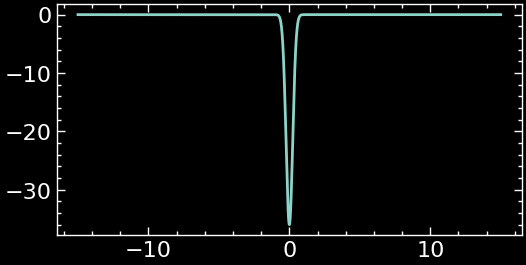

In [100]:
plt.figure(figsize=(6,3))
plt.plot(x, V(x,V0))
plt.show()

In [101]:
Es, psis = solve_single_well(x, V, V0)

Look at the energies

In [102]:
f*Es

array([-21.37895221,  -1.35778458])

Plot all the wavefunctions

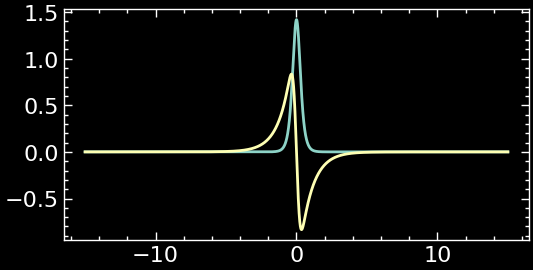

In [103]:
plt.figure(figsize=(6,3))
[plt.plot(x, psi) for psi in psis]
plt.show()

In order to solve our integral, lets create a function that can compute the wavefunctions at any point $x$

In [104]:
psis_f = [interp1d(x, psi, bounds_error=False, fill_value=(0,0)) for psi in psis]

Define $\hat{V}(x)$: the potential from all the wells, **except** the one centered at $x=0$.

In [106]:
def Vp_f(x, b, V0):
    return V((x+b/2)%b-b/2,V0) - V(x,V0)

Plot the ground state wavefunctions from consecutive wells, along with $\hat{V}(x)$

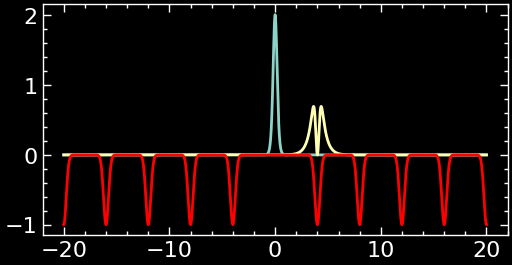

In [107]:
x_large = np.linspace(-20,20,10000)
plt.figure(figsize=(6,3))
plt.plot(x_large, psis_f[0](x_large)**2)
plt.plot(x_large, psis_f[1](x_large - b)**2)
plt.plot(x_large, Vp_f(x_large,b,V0)/V0, color='red')
plt.show()

Function that computes $\int_{-\infty}^{\infty} \phi_i^{*}(x) \left[E_i+\hat{V}(x)\right]\phi_{i'}(x \pm nb) dx$

In [108]:
def compute_integral(psis_f, Es, i1, i2, b, V0, n):
    return quad(lambda x: psis_f[i1](x)*psis_f[i2](x-n*b)*(Es[i1]+Vp_f(x, b, V0)),
                -20, 20, points=[n*b for n in range(-6,6)], limit=1000)[0]  

In [109]:
f*compute_integral(psis_f,Es,0,0, b=6, V0=V0, n=1)

-1.5380149840051426e-09

## Fill the Hamiltonian matrix $H$

**Part 1**: Create Matrix

In [110]:
N_states

2

In [111]:
N_wells = 20
N_states = len(Es)
H = np.zeros((N_wells*N_states,N_wells*N_states))

**Part 2**: Fill Off diagonals

In [112]:
psis_tot = N_wells*psis_f
Es_tot = N_wells*list(Es)
for i1 in range(H.shape[0]):
    for i2 in range(i1, H.shape[0]):
        well1_idx = i1//N_states
        well2_idx = i2//N_states
        H[i1,i2] = compute_integral(psis_tot,Es_tot,i1,i2,b=b,V0=V0,n=well2_idx-well1_idx)
H += H.T

**Part 3**: Fill Main diagonal

In [113]:
main_diag = np.array(list(Es)*N_wells)
H[np.diag_indices(H.shape[0])] = main_diag

Show a visual representation of the Hamiltonian

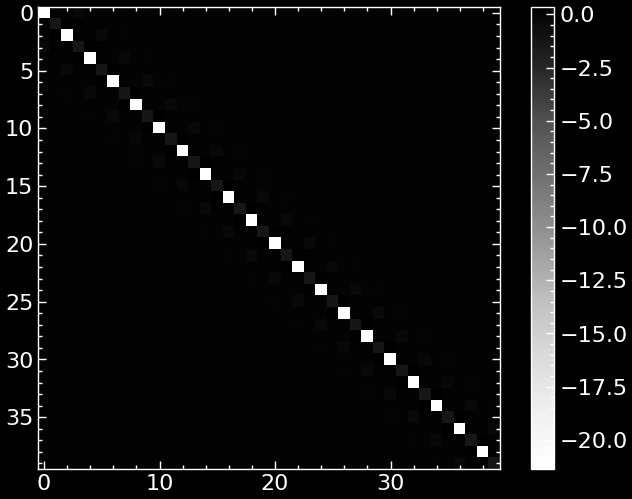

In [114]:
plt.imshow(H, cmap='Greys')
plt.colorbar()
plt.show()

Solve for the allowed energies and states of an electron in this system:

In [115]:
eigenenergies, eigenvectors = np.linalg.eigh(H)

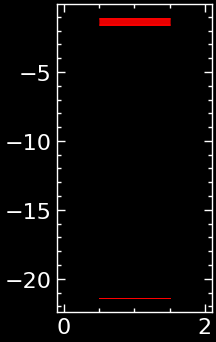

In [116]:
plt.figure(figsize=(2,4))
plt.eventplot(f*eigenenergies, orientation='vertical', colors='r', linewidths=0.5)
plt.show()

In [117]:
eigenenergies

array([-21.40124597, -21.40124536, -21.39977253, -21.39977022,
       -21.39746258, -21.39745779, -21.39452121, -21.39451363,
       -21.39120959, -21.39119943, -21.38782184, -21.38780979,
       -21.38465895, -21.38464591, -21.38200216, -21.38198881,
       -21.38008837, -21.38007387, -21.37909388, -21.37906423,
        -1.59169285,  -1.58355975,  -1.57019826,  -1.55189484,
        -1.52904249,  -1.50213293,  -1.47174689,  -1.43854263,
        -1.40324295,  -1.36662076,  -1.32948347,  -1.2926563 ,
        -1.25696471,  -1.22321615,  -1.19218148,  -1.16457641,
        -1.1410434 ,  -1.12213481,  -1.10829764,  -1.09986093])

**For example 1**: Theoretically, the allowed energies are 

In [ ]:
idx = eigenenergies>-1

In [ ]:
f* (max(eigenenergies[idx]) - min(eigenenergies[idx]))